In [1]:
import pandas as pd
import numpy as np
import datetime
import gc
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import NMF, PCA
from sklearn.externals import joblib
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
import random
# graphics TP1
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# Sampling
---

## objetivo

Escoger suficientes device IDs para que auctions sean 100,000 registros.

## Hipotesis

Un sample de device IDs obteniendo todos sus registros relacionados en los diferentes datasets al device ID conservan las propiedades de la distribucion de los datos.

## Pasos

1. Procesar con el TP1 los nuevos datos
2. Hacer un archivo con todos los device IDs de Auctions
3. Seleccionar al azar device IDs del archivo y buscar todos sus registros en auctions hasta que sean 100,000 registros
4. Procesar el sample como el TP1 para ver que la muestra sea valida. Es decir los graficos tienen que ser parecidos

### 1. Procesar con el TP1 los nuevos datos

1. ¿Qué franja horaria contuvo la mayor cantidad de subastas?
2. Una vez que la etapa de subasta terminó y se realizó la impresión en el dispositivo, ¿dónde nuestros consumidores realizaron clicks en la pantalla? ¿por qué ahí? La concentración de clicks en la pantalla al aparecer una publicidad tienen un por qué, y es lo que intentaremos definir.
3. ¿Qué franja horaria contuvo la mayor cantidad de events?
4. ¿Cuáles clicks generaron conversiones en events?
5. ¿En qué franja horaria se produjo la mayor cantidad de instalaciones?¶
6. ¿Cuáles fueron las 4 aplicaciones más instaladas?
7. ¿Estar conectado a internet vía wifi tuvo peso a la hora de definir si el consumidor instaló ?
8. ¿Cuáles fueron las Apps más instaladas con wifi?
9. Si el tipo de conexión en installs tuvo gran importancia ¿tendrá un peso similar la conexión vía wifi en los eventos?
10. ¿Cuáles clicks generaron conversiones en installs?
11. ¿Cuáles fueron las distribuciones de los eventos de la muestra ?¿Y de los installs?
12. ¿Cuáles fueron los tiempos de conversión ?
13. ¿Cuál fue la distribución de los eventos de Jammp ? Los más frecuentes.
14. Eventos por usuario.
15. Eventos por aplicación.
16. ¿Se intersectarán los clicks e installs según el usuario? ¿Existirá una proporción?
17. ¿Existirá una relación entre los clientes y las aplicaciones ?

In [3]:
def fix_str_float(ds, col):
    ds[col] = ds[col].str.replace(r'[^0-9\.]','')
    ds[col] = np.where(ds[col]=='',np.nan,ds[col])
    ds[col] = ds[col].astype('float32')
    return ds[col].astype('float32')

In [4]:
# clicks
clicks_df = pd.read_csv('data/clicks.csv', low_memory=False,dtype={'advertiser_id':'int32','action_id':'float32','source_id':'int32','country_code':'category',\
                                                 'latitude':'float32','longitude':'float32','carrier_id':'float32','os_minor':'category',\
                                                  'os_major':'category','specs_brand':'category','timeToClick':'float32','ref_type':'category'\
                                                                  ,'ref_hash':'object'})

clicks_df['touchX'] = fix_str_float(clicks_df,'touchX')
clicks_df['touchY'] = fix_str_float(clicks_df,'touchY')
clicks_df['created'] = pd.to_datetime(clicks_df['created'])
#events
events_df = pd.read_csv('data/events.csv', low_memory=False, dtype={'event_id':'int32','ref_type':'category','application_id':'category',\
                                                                                            'attributed':'bool','device_countrycode':'category','device_city':'category',\
                                                                                            'trans_id':'category','carrier':'category','device_os':'category',\
                                                                                            'connection_type':'category'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df['wifi'].astype('bool', inplace=True)
events_df.drop(columns=['device_countrycode','session_user_agent','ip_address','device_language'], inplace=True)
# installs
installs_df = pd.read_csv('data/installs.csv', low_memory=False, dtype={'ref_type':'category','application_id':'category',\
                                                      'device_brand':'category','ref_hash':'object','wifi':'category'})
installs_df['kind'] = installs_df['kind'].str.lower()
installs_df['kind'] = installs_df['kind'].astype('category')
installs_df.drop(columns=['session_user_agent','ip_address','device_language','device_model'], inplace=True)
installs_df['created'] = pd.to_datetime(installs_df['created'])
installs_df.drop(['device_countrycode'], axis=1, inplace=True)
# auctions
auctions_df = pd.read_csv('data/auctions.csv', low_memory=False, dtype={'country':'category','platform':'category',\
                                                                        'ref_type_id':'category','source_id':'category','device_id':'object'})

auctions_df['date'] = pd.to_datetime(auctions_df['date'])
allDone()
print('setup done')


setup done


#### 1. ¿Qué franja horaria contuvo la mayor cantidad de subastas?

In [5]:
auctions_df.drop_duplicates(inplace=True)
auctions_df['hora'] = auctions_df['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
auctions_df['dia'] = auctions_df['date'].dt.day_name()+' '+auctions_df['date'].dt.day.map(str)
pivot_auctions = auctions_df.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'count']
pivot_auctions = pivot_auctions.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_auctions = pivot_auctions[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]
allDone()
#display(pivot_auctions)



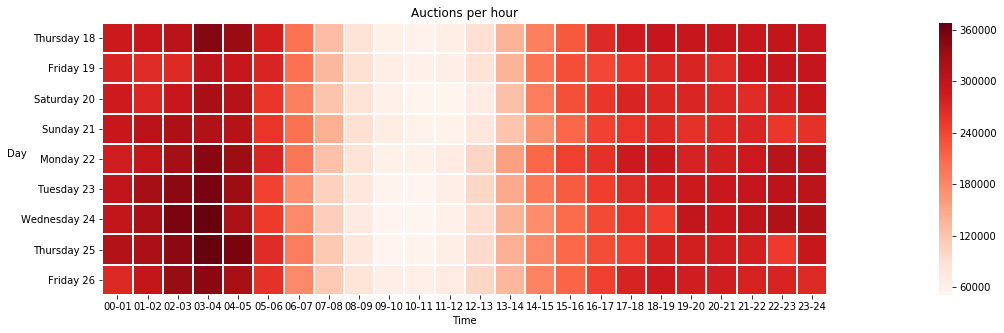

In [6]:
plt.figure(figsize = (40,5))
plt.title('Auctions per hour')
sns.heatmap(pivot_auctions.T, square = True, linewidth=1, cmap = 'Reds');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### 3. ¿Qué franja horaria contuvo la mayor cantidad de events?

In [7]:
events_df['hora'] = events_df['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
events_df['dia'] = events_df['date'].dt.day_name()+' '+events_df['date'].dt.day.map(str)
pivot_events = events_df.groupby(['dia','hora']).size().reset_index()
pivot_events.columns = ['dia','hora', 'count']
pivot_events = pivot_events.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_events = pivot_events[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]


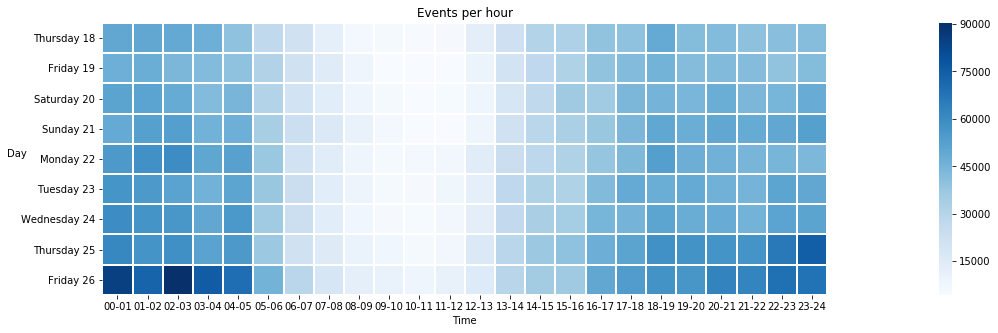

In [8]:
plt.figure(figsize = (40,5))
plt.title('Events per hour')
sns.heatmap(pivot_events.T, square = True, linewidth=1, cmap = 'Blues');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### 5. ¿En qué franja horaria se produjo la mayor cantidad de instalaciones?

In [9]:
installs_df['hora'] = installs_df['created'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
installs_df['dia'] = installs_df['created'].dt.day_name()+' '+installs_df['created'].dt.day.map(str)
pivot_installs = installs_df.groupby(['dia','hora']).size().reset_index()
pivot_installs.columns = ['dia','hora', 'count']
pivot_installs = pivot_installs.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_installs = pivot_installs[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]


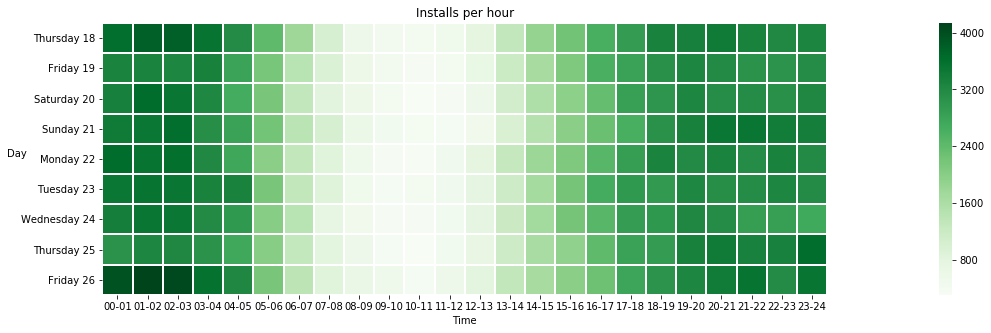

In [10]:
plt.figure(figsize = (40,5));
plt.title('Installs per hour');
sns.heatmap(pivot_installs.T, square = True, linewidth=1, cmap = 'Greens');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### 11. ¿Cuáles fueron las distribuciones de los eventos de la muestra ?¿Y de los installs?

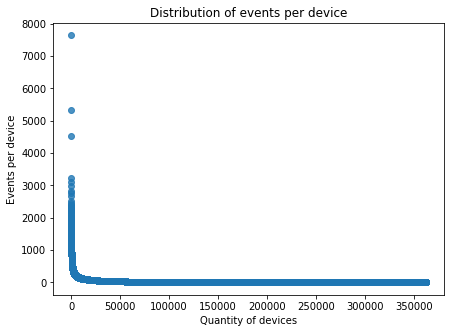

In [11]:
plt.figure(figsize = (7,5));
device_freq = events_df['ref_hash'].value_counts().to_frame().reset_index().reset_index()
device_freq.columns = ['x', 'ref_hash', 'count']

ax = sns.regplot(x=device_freq['x'], y=device_freq['count'], fit_reg=False);
ax.set_xlabel('Quantity of devices');
ax.set_ylabel('Events per device');
ax.set_title('Distribution of events per device');

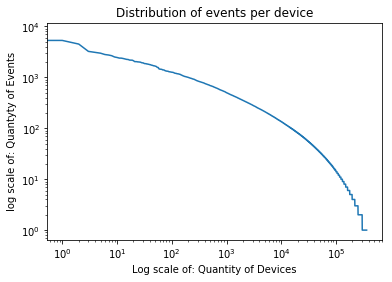

In [12]:
ax = device_freq.plot(x='x',y='count',loglog=True, legend=False);
ax.set_xlabel('Log scale of: Quantity of Devices');
ax.set_ylabel('log scale of: Quantyty of Events');
ax.set_title('Distribution of events per device');

### 2. Hacer un archivo con todos los device IDs de Auctions

Los IDs no pueden permanecer al target

In [5]:
sample_percentage = 0.5/100; # 1%

In [7]:
competencia_ids = pd.read_csv('data/target_competencia_ids.csv')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_sc', '')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_st', '')
competencia_ids.drop_duplicates(inplace=True)
pd.DataFrame(auctions_df.loc[~auctions_df['device_id'].isin(competencia_ids['ref_hash'])]['device_id'].unique(), columns=['device_id'], dtype='object').to_csv('data/auctions_ids.csv', index=False)



### 3. Seleccionar al azar device IDs del archivo y buscar todos sus registros en auctions hasta que sean 100,000 registros

Al menos 100,000 registros por ventana

#### Auctions

In [8]:
auctions_ids = pd.read_csv('data/auctions_ids.csv', dtype={'device_id':'object'})

In [9]:
sample_size = auctions_ids.shape[0]

In [10]:
auctions_ids_sample = auctions_ids['device_id'].sample(n=int(sample_size*sample_percentage), random_state=3)
#save sample ids
auctions_ids_sample.to_frame().to_csv('data/auctions_ids_sample.csv', index=False)

In [18]:
#auctions sample
auctions_sample = auctions_df.loc[auctions_df['device_id'].isin(auctions_ids_sample)].copy()
display(auctions_df.shape)
auctions_sample.shape

(47409528, 6)

(490041, 6)

In [19]:
n = sum(1 for line in open('data/auctions_ids_sample.csv'))-1  # Calculate number of rows in file
n

4713

#### Installs

In [20]:
installs_sample = installs_df.loc[installs_df['ref_hash'].isin(auctions_ids_sample)].copy()

#### Events

In [21]:
events_sample = events_df.loc[events_df['ref_hash'].isin(auctions_ids_sample)].copy()

### 4. Procesar el sample como el TP1 para ver que la muestra sea valida. Es decir los graficos tienen que ser parecidos

#### Auctions

In [22]:
auctions_sample['hora'] = auctions_sample['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
auctions_sample['dia'] = auctions_sample['date'].dt.day_name()+' '+auctions_sample['date'].dt.day.map(str)
pivot_auctions = auctions_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'count']
pivot_auctions = pivot_auctions.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_auctions = pivot_auctions[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]
#display(pivot_auctions)



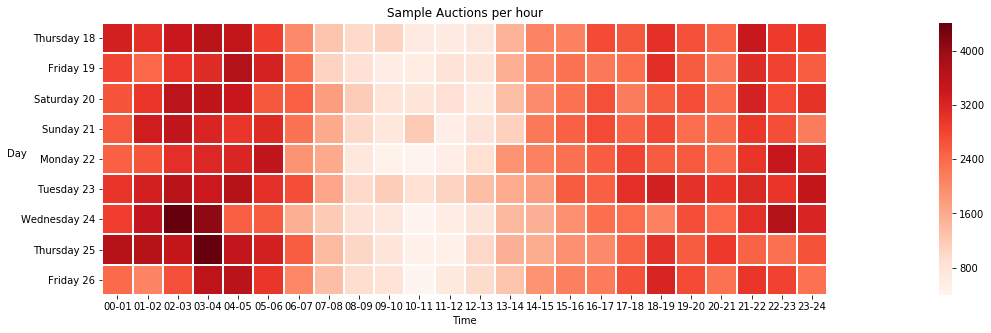

In [23]:
plt.figure(figsize = (40,5))
plt.title('Sample Auctions per hour')
sns.heatmap(pivot_auctions.T, square = True, linewidth=1, cmap = 'Reds');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### Events

In [24]:
events_sample['hora'] = events_sample['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
events_sample['dia'] = events_sample['date'].dt.day_name()+' '+events_sample['date'].dt.day.map(str)
pivot_events = events_sample.groupby(['dia','hora']).size().reset_index()
pivot_events.columns = ['dia','hora', 'count']
pivot_events = pivot_events.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_events = pivot_events[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]



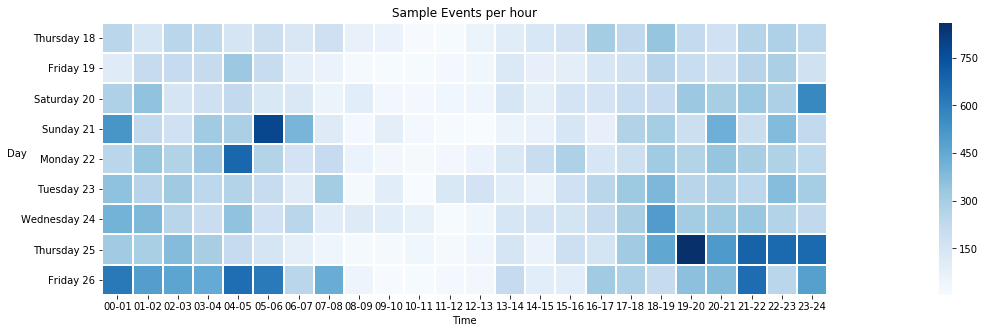

In [25]:
plt.figure(figsize = (40,5))
plt.title('Sample Events per hour')
sns.heatmap(pivot_events.T, square = True, linewidth=1, cmap = 'Blues');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### Installs

In [26]:
installs_sample['hora'] = installs_sample['created'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
installs_sample['dia'] = installs_sample['created'].dt.day_name()+' '+installs_sample['created'].dt.day.map(str)
pivot_installs = installs_sample.groupby(['dia','hora']).size().reset_index()
pivot_installs.columns = ['dia','hora', 'count']
pivot_installs = pivot_installs.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_installs = pivot_installs[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]


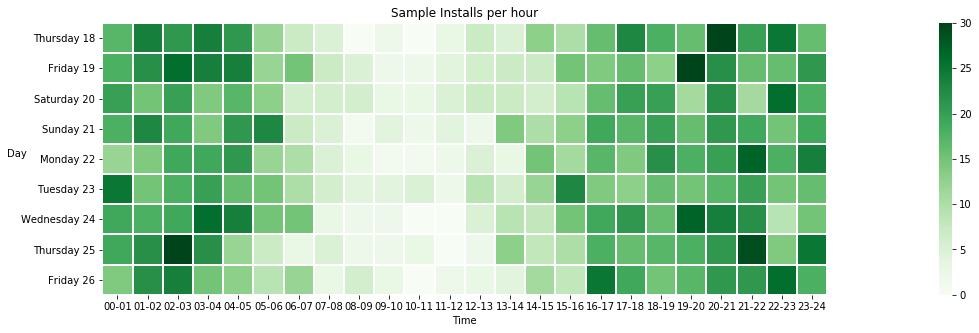

In [27]:
plt.figure(figsize = (40,5));
plt.title('Sample Installs per hour');
sns.heatmap(pivot_installs.T, square = True, linewidth=1, cmap = 'Greens');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### Distribución

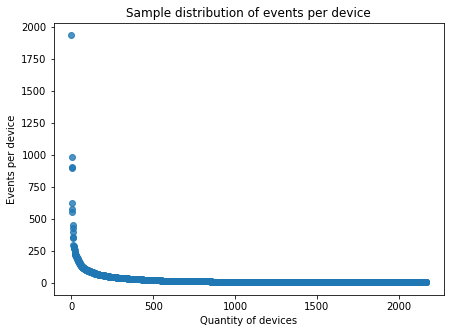

In [28]:
plt.figure(figsize = (7,5));
device_freq = events_sample['ref_hash'].value_counts().to_frame().reset_index().reset_index()
device_freq.columns = ['x', 'ref_hash', 'count']

ax = sns.regplot(x=device_freq['x'], y=device_freq['count'], fit_reg=False);
ax.set_xlabel('Quantity of devices');
ax.set_ylabel('Events per device');
ax.set_title('Sample distribution of events per device');

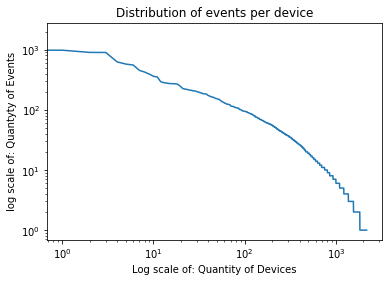

In [29]:
ax = device_freq.plot(x='x',y='count',loglog=True, legend=False);
ax.set_xlabel('Log scale of: Quantity of Devices');
ax.set_ylabel('log scale of: Quantyty of Events');
ax.set_title('Distribution of events per device');

In [30]:
allDone()